In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import hist
from hist import Hist
import pandas as pd

def load_dataset(file_path, detector_name="VirtualDetector"):
    """
    Load a dataset from a ROOT file.

    Args:
        file_path (str): Path to the ROOT file.
        detector_name (str): Name of the virtual detector group inside the file.
    
    Returns:
        uproot.ReadOnlyDirectory: The uproot directory containing detector data.
    """
    try:
        dataset = uproot.open(file_path)[detector_name]
        print(f"Loaded dataset: {file_path}")
        return dataset
    except Exception as e:
        print(f"Error loading dataset {file_path}: {e}")
        return None

def list_detector_keys(dataset):
    """
    List all available virtual detectors in the dataset.

    Args:
        dataset (uproot.ReadOnlyDirectory): The dataset object.
    
    Returns:
        list: List of keys (detector positions) in the dataset.
    """
    if dataset:
        return dataset.keys()
    return []

def get_virtual_detector_data(dataset, detector_key, variable_key):
    """
    Retrieve data from a specific virtual detector and variable.

    Args:
        dataset (uproot.ReadOnlyDirectory): The dataset object.
        detector_key (str): The virtual detector position key.
        variable_key (str): The variable to extract (e.g., 'PDGid', 'x', 'y').

    Returns:
        awkward.Array: The extracted data or None if the key is not found.
    """
    if dataset is None:
        print(f"Dataset is not loaded properly.")
        return None
    
    if detector_key not in dataset:
        print(f"Detector key '{detector_key}' not found in the dataset. Available keys: {dataset.keys()}")
        return None
    
    if variable_key not in dataset[detector_key].keys():
        print(f"Variable key '{variable_key}' not found in '{detector_key}'. Available keys: {dataset[detector_key].keys()}")
        return None
    
    try:
        return dataset[detector_key][variable_key].array()
    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

def plot_1D_histogram(data, xlabel, title, bins=None, xlim=None, discrete=False, save_path=None):
    """
    Plot a 1D histogram with automatic bin width of 1 if bins are not specified.

    Args:
        data (array-like): The data to plot.
        xlabel (str): Label for the x-axis.
        title (str): Title of the histogram.
        bins (int or None): Number of bins (if None, auto-bin width = 1).
        xlim (tuple or None): (min, max) limits for x-axis.
        discrete (bool): If True, treat data as discrete and use a bar plot.
    """
    # Convert awkward arrays to numpy if needed
    data = ak.to_numpy(ak.flatten(data, axis=None)) if isinstance(data, ak.Array) else np.array(data)

    # Auto-detect binning if bins is not provided
    if bins is None:
        data_min, data_max = data.min(), data.max()
        if xlim is not None:
            data_min, data_max = xlim  # Override with xlim if given
        bins = np.arange(data_min, data_max + 1, 1)  # Ensure bin width = 1

    plt.figure(figsize=(8, 6))

    if discrete:
        # Discrete case: Use bar plot
        unique_values, counts = np.unique(data, return_counts=True)
        plt.bar(unique_values, counts, width=10.0, edgecolor='black', alpha=0.7)
        plt.xticks(unique_values)
    else:
        # Continuous case: Use histogram
        plt.hist(data, bins=bins, alpha=0.7, edgecolor='black')

    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True)

    # Set x-axis limits if provided
    if xlim is not None:
        plt.xlim(xlim)

    # Save plot if save_path is specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-resolution PNG
        print(f"Plot saved to {save_path}")

    plt.show()

def plot_1D_histogram_overlay(datasets, labels, xlabel, title, bins=None, alpha=0.7, colors=None, xmin=None, xmax=None, discrete=False, save_path=None):
    """
    Plot overlaid 1D histograms for multiple datasets with auto binning and discrete support.

    Args:
        datasets (list of array-like): List of datasets to plot.
        labels (list of str): List of labels corresponding to each dataset.
        xlabel (str): Label for the x-axis.
        title (str): Title of the histogram.
        bins (int or None): Number of bins (if None, auto bin width = 1).
        alpha (float): Transparency for better visibility.
        colors (list of str): List of colors for each dataset.
        xmin (float): Minimum x-axis value (optional).
        xmax (float): Maximum x-axis value (optional).
        discrete (bool): If True, use bar plots based on unique values.
        save_path (str): Optional path to save the plot as a PNG file.
    """
    # Convert awkward arrays to numpy if needed
    datasets = [ak.to_numpy(ak.flatten(data, axis=None)) if isinstance(data, ak.Array) else np.array(data) for data in datasets]

    # Determine plot range
    data_min = min(min(d) for d in datasets)
    data_max = max(max(d) for d in datasets)

    if xmin is not None:
        data_min = xmin
    if xmax is not None:
        data_max = xmax

    # Define colors if not provided
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

    plt.figure(figsize=(8, 6))

    if discrete:
        # For discrete values, use bar plots
        unique_values = np.unique(np.concatenate(datasets))
        for data, label, color in zip(datasets, labels, colors):
            counts, _ = np.histogram(data, bins=np.append(unique_values, unique_values[-1] + 1))
            plt.bar(unique_values, counts, width=10.0, alpha=alpha, edgecolor='black', label=label, color=color)
        plt.xticks(unique_values)
    else:
        # For continuous data, use overlaid histograms
        if bins is None:
            bins = np.arange(data_min, data_max + 1, 1)  # Auto bin width = 1
        for data, label, color in zip(datasets, labels, colors):
            plt.hist(data, bins=bins, alpha=alpha, edgecolor='black', label=label, color=color)

    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if xmin is not None and xmax is not None:
        plt.xlim(xmin, xmax)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()


def plot_1D_histogram_stacked(datasets, labels, xlabel, title, bins=None, alpha=0.7, colors=None, xmin=None, xmax=None, discrete=False, save_path=None):
    """
    Plot a stacked 1D histogram for multiple datasets with auto binning based on data range.

    Args:
        datasets (list of array-like): List of datasets to plot.
        labels (list of str): List of labels corresponding to each dataset.
        xlabel (str): Label for the x-axis.
        title (str): Title of the histogram.
        bins (int or None): Number of bins (if None, auto-bin width = 1).
        alpha (float): Transparency for better visibility.
        colors (list of str): List of colors for each dataset.
        xmin (float): Minimum x-axis value (if None, auto-detect from data).
        xmax (float): Maximum x-axis value (if None, auto-detect from data).
        discrete (bool): If True, treat data as discrete and use a bar plot.
    """
    # Convert awkward arrays to numpy if needed
    datasets = [ak.to_numpy(ak.flatten(data, axis=None)) if isinstance(data, ak.Array) else np.array(data) for data in datasets]

    # Auto-detect bin range
    if bins is None:
        data_min = min(min(d) for d in datasets)
        data_max = max(max(d) for d in datasets)
        if xmin is not None and xmax is not None:
            data_min, data_max = xmin, xmax  # Override with given range
        bins = np.arange(data_min, data_max + 1, 1)  # Ensure bin width = 1

    plt.figure(figsize=(8, 6))

    if discrete:
        # Discrete case: Use bar plot
        unique_values = np.unique(np.concatenate(datasets))
        counts_list = [np.histogram(d, bins=np.append(unique_values, unique_values[-1] + 1))[0] for d in datasets]

        for counts, label, color in zip(counts_list, labels, colors or plt.cm.viridis(np.linspace(0, 1, len(datasets)))):
            plt.bar(unique_values, counts, width=10.0, alpha=alpha, edgecolor='black', label=label, color=color)
        plt.xticks(unique_values)
    else:
        # Continuous case: Use histogram
        plt.hist(datasets, bins=bins, stacked=True, alpha=alpha, label=labels, color=colors or plt.cm.viridis(np.linspace(0, 1, len(datasets))), edgecolor='black')

    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Set x-axis limits if provided
    if xmin is not None and xmax is not None:
        plt.xlim(xmin, xmax)

    # Save plot if save_path is specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-resolution PNG
        print(f"Plot saved to {save_path}")

    plt.show()

def plot_2D_histogram(data_x, data_y, xlabel, ylabel, title, xlim=None, ylim=None, vmin=None, vmax=None, bins=50, save_path=None):
    """
    Plot a 2D histogram with optional axis and color range control.

    Args:
        data_x (array-like): X-axis data.
        data_y (array-like): Y-axis data.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the histogram.
        xlim (tuple): (min, max) for x-axis.
        ylim (tuple): (min, max) for y-axis.
        vmin (float): Min value for color scale.
        vmax (float): Max value for color scale.
        bins (int): Number of bins (default: 50).
    """
    plt.figure(figsize=(8, 6))

    # Ensure proper conversion from awkward array to numpy
    data_x = ak.to_numpy(ak.flatten(data_x, axis=None)) if isinstance(data_x, ak.Array) else np.array(data_x)
    data_y = ak.to_numpy(ak.flatten(data_y, axis=None)) if isinstance(data_y, ak.Array) else np.array(data_y)

    # Remove any NaN values that may cause issues
    valid_mask = ~np.isnan(data_x) & ~np.isnan(data_y)
    data_x = data_x[valid_mask]
    data_y = data_y[valid_mask]

    # Create histogram
    h = plt.hist2d(data_x, data_y, bins=bins, cmap="viridis", vmin=vmin, vmax=vmax)

    plt.colorbar(label="Count")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Apply axis limits only if specified
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.grid(True)

    # Save plot if save_path is specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-resolution PNG
        print(f"Plot saved to {save_path}")
        
    plt.show()

def plot_scatter(data_x, data_y, xlabel, ylabel, title, xlim=None, ylim=None, alpha=1.0, s=10, save_path=None):
    """
    Plot a scatter plot for x vs y.
    
    Args:
        data_x (array-like): X-axis data.
        data_y (array-like): Y-axis data.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
        xlim (tuple): (min, max) for x-axis.
        ylim (tuple): (min, max) for y-axis.
        alpha (float): Transparency of points.
        s (int): Marker size.
    """
    plt.figure(figsize=(8, 6))

    # Convert Awkward arrays to NumPy only if necessary
    if isinstance(data_x, ak.Array):
        if data_x.ndim > 1:  # Check if it's nested
            data_x = ak.to_numpy(ak.flatten(data_x))
        else:
            data_x = ak.to_numpy(data_x)

    if isinstance(data_y, ak.Array):
        if data_y.ndim > 1:
            data_y = ak.to_numpy(ak.flatten(data_y))
        else:
            data_y = ak.to_numpy(data_y)

    # Default limits
    if xlim is None:
        xlim = (np.min(data_x), np.max(data_x))
    if ylim is None:
        ylim = (np.min(data_y), np.max(data_y))

    # Scatter plot
    plt.scatter(data_x, data_y, alpha=alpha, s=s, color="blue")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True)

    # Save plot if save_path is specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-resolution PNG
        print(f"Plot saved to {save_path}")

    plt.show()
    
def filter_by_pdgid(data_pdgid, pdg_values):
    """
    Filter data based on specific PDG ID values.

    Args:
        data_pdgid (awkward.Array): PDG ID data array.
        pdg_values (int or list): Single PDG ID or a list of PDG IDs to filter.

    Returns:
        awkward.Array: Boolean mask selecting only the desired PDG IDs.
    """
    # Ensure pdg_values is a list
    if not isinstance(pdg_values, (list, tuple)):
        pdg_values = [pdg_values]

    return ak.any(data_pdgid[:, None] == ak.Array(pdg_values), axis=1)

In [2]:
# Load datasets
dataset_1000 = load_dataset('./TungstenTarget-50x50x1000_Solenoid-4T-3000x12500/TungstenTarget-50x50x1000_Solenoid-4T-3000x12500.root')
dataset_600 = load_dataset('./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/TungstenTarget-50x50x600_Solenoid-4T-3000x12500.root')
dataset_200 = load_dataset('./TungstenTarget-50x50x200_Solenoid-4T-3000x12500/TungstenTarget-50x50x200_Solenoid-4T-3000x12500.root')

# List available detectors
detectors_1000 = list_detector_keys(dataset_1000)
detectors_600 = list_detector_keys(dataset_600)
detectors_200 = list_detector_keys(dataset_200)
print("Available Detectors in Dataset 1000:", detectors_1000)
print("Available Detectors in Dataset 600:", detectors_600)
print("Available Detectors in Dataset 200:", detectors_200)

# Choose a virtual detector position
detector_key_1000 = "Det_1150cm_Solenoid"
detector_key_600 = "Det_1190cm_Solenoid"
detector_key_200 = "Det_1230cm_Solenoid"

# Extract PDG ID data from the chosen detector
pdg_ids_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "PDGid")
pdg_ids_600 = get_virtual_detector_data(dataset_600, detector_key_600, "PDGid")
pdg_ids_200 = get_virtual_detector_data(dataset_200, detector_key_200, "PDGid")

Loaded dataset: ./TungstenTarget-50x50x1000_Solenoid-4T-3000x12500/TungstenTarget-50x50x1000_Solenoid-4T-3000x12500.root
Loaded dataset: ./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/TungstenTarget-50x50x600_Solenoid-4T-3000x12500.root
Loaded dataset: ./TungstenTarget-50x50x200_Solenoid-4T-3000x12500/TungstenTarget-50x50x200_Solenoid-4T-3000x12500.root
Available Detectors in Dataset 1000: ['Det_-50cm_Solenoid;1', 'Det_400cm_Solenoid;1', 'Det_600cm_Solenoid;1', 'Det_800cm_Solenoid;1', 'Det_1000cm_Solenoid;1', 'Det_1150cm_Solenoid;1', 'Det_2000cm_Solenoid;1', 'Det_3000cm_Solenoid;1', 'Det_4000cm_Solenoid;1', 'DetBackward_Solenoid;1', 'DetSideways_Solenoid;1', 'DetForward_Solenoid;1']
Available Detectors in Dataset 600: ['Det_-30cm_Solenoid;1', 'Det_400cm_Solenoid;1', 'Det_600cm_Solenoid;1', 'Det_800cm_Solenoid;1', 'Det_1000cm_Solenoid;1', 'Det_1190cm_Solenoid;1', 'Det_2000cm_Solenoid;1', 'Det_3000cm_Solenoid;1', 'Det_4000cm_Solenoid;1', 'DetBackward_Solenoid;1', 'DetSideways_Solenoid

Plot saved to PDGID_1000mm_muons_pions_kaons.png


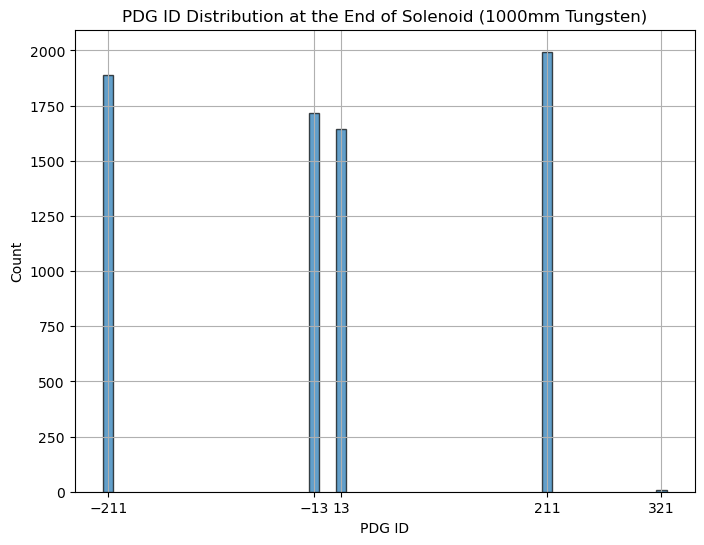

Plot saved to PDGID_600mm_muons_pions_kaons.png


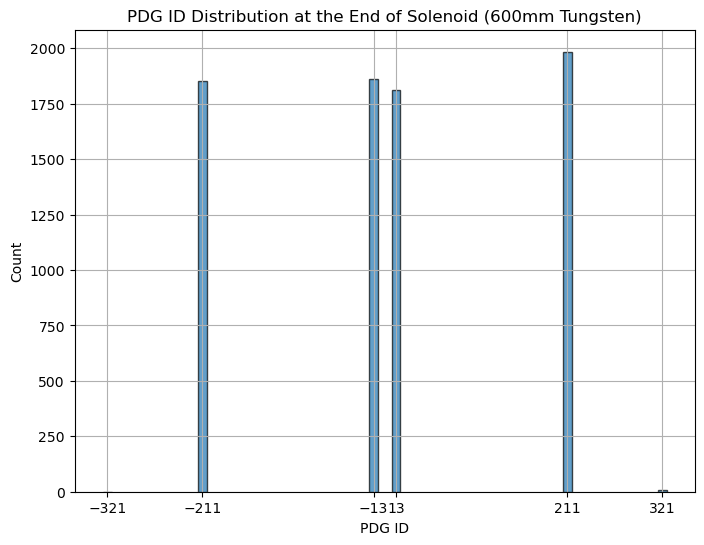

Plot saved to PDGID_200mm_muons_pions_kaons.png


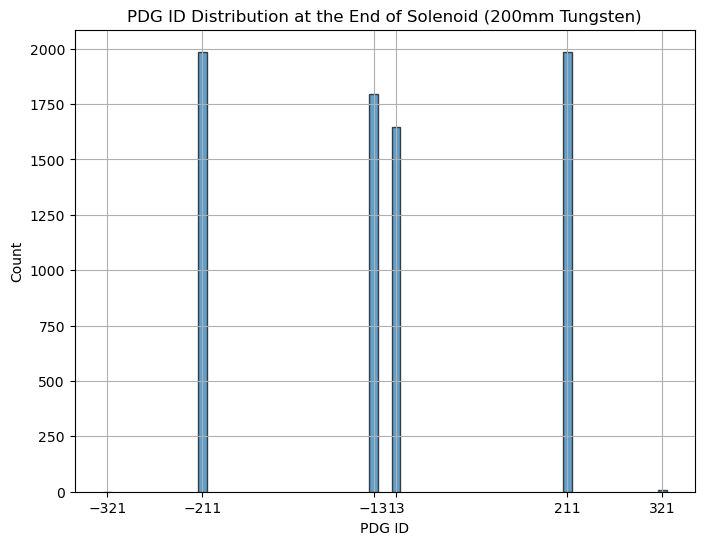

Plot saved to PDGID_1000mm_protons.png


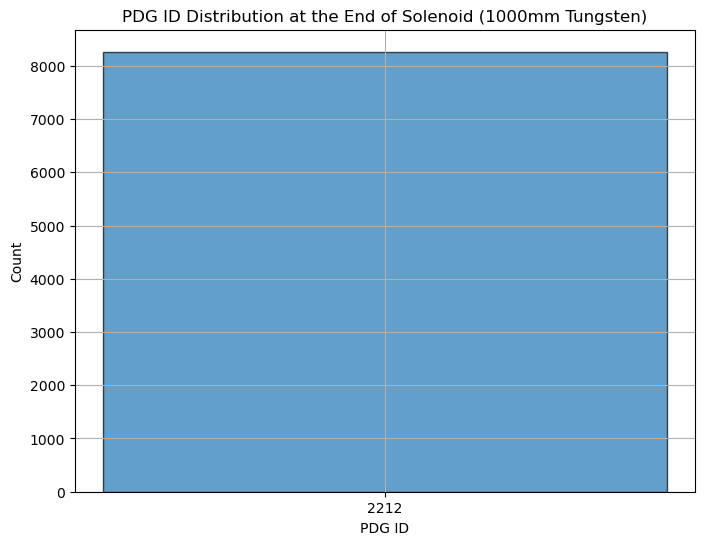

Plot saved to PDGID_600mm_protons.png


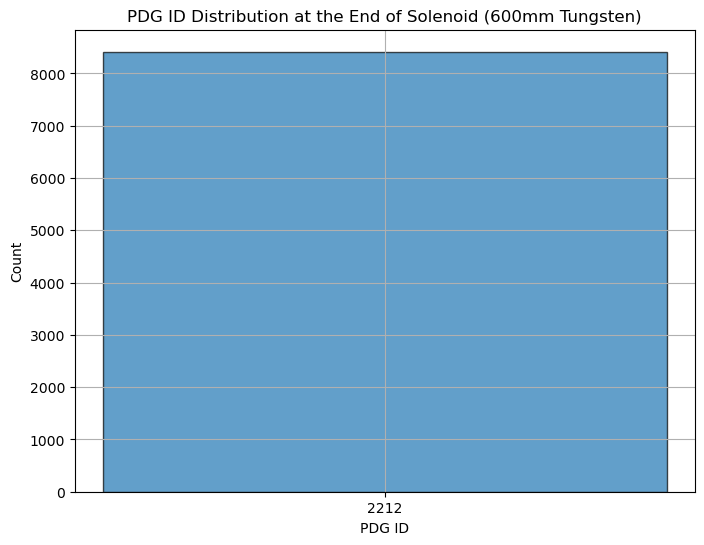

Plot saved to PDGID_200mm_protons.png


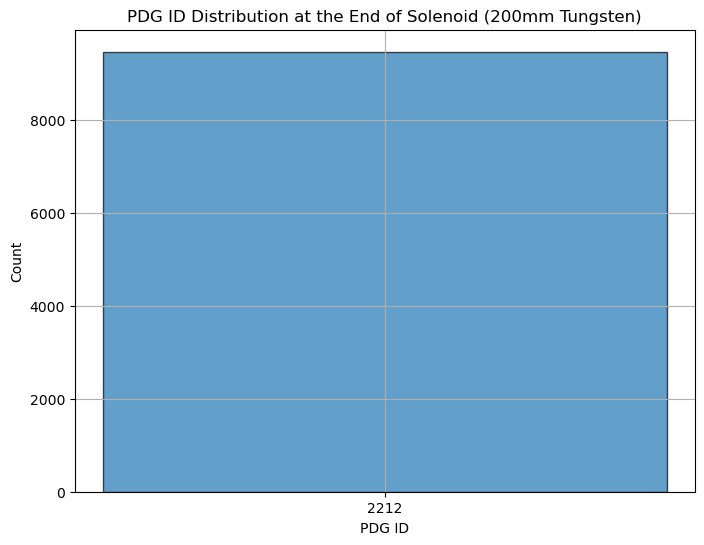

Plot saved to E_Protons_1000mm.png


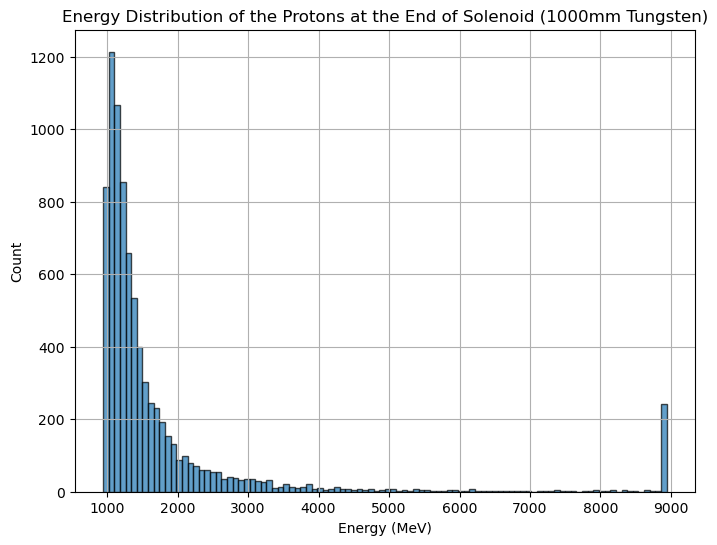

Plot saved to E_Protons_600mm.png


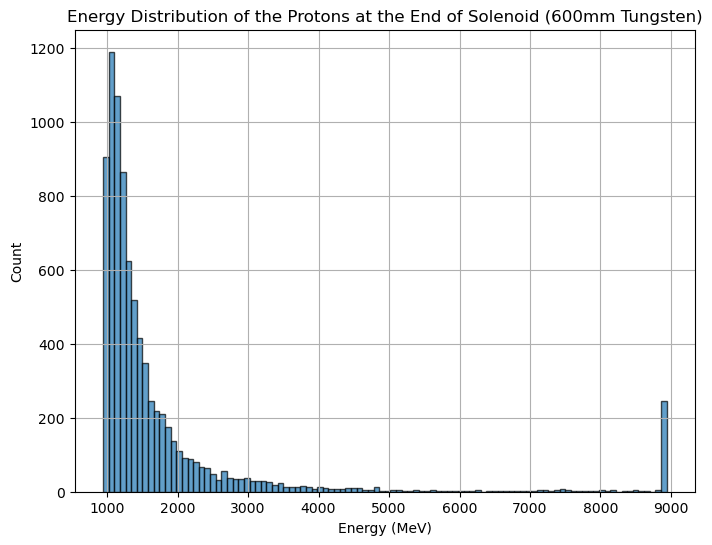

Plot saved to E_Protons_200mm.png


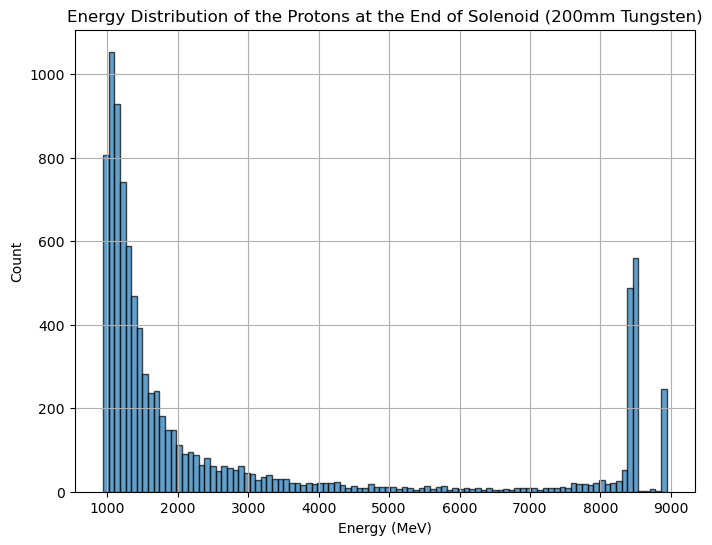

Plot saved to E_Muons_1000mm.png


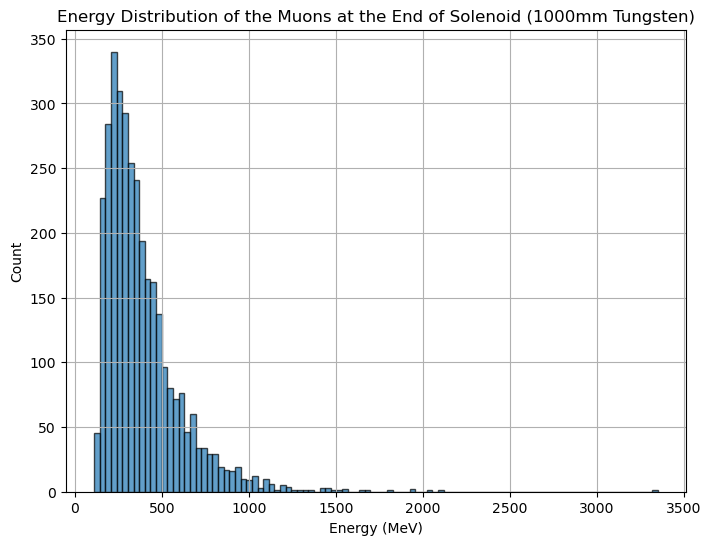

Plot saved to E_Muons_600mm.png


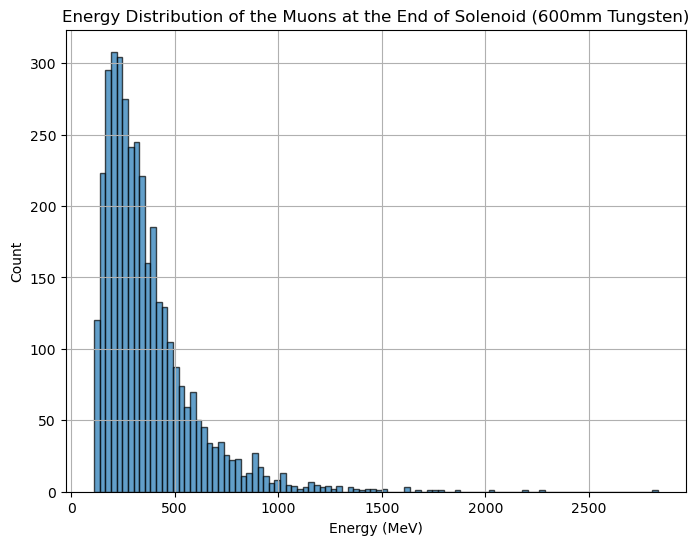

Plot saved to E_Muons_200mm.png


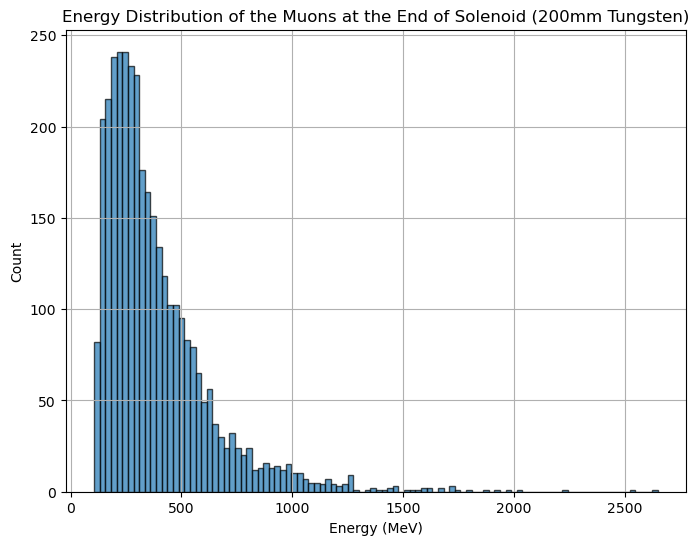

Plot saved to Compare_PDGID_TungstenSize.png


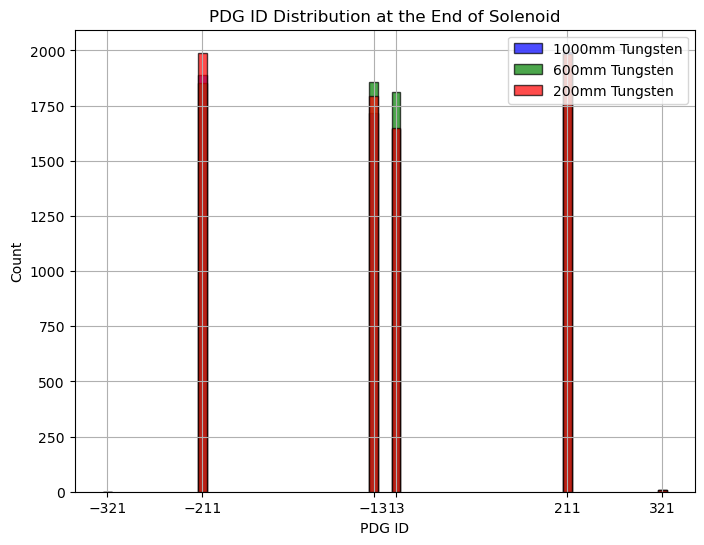

Plot saved to Compare_EMuons_TungstenSize.png


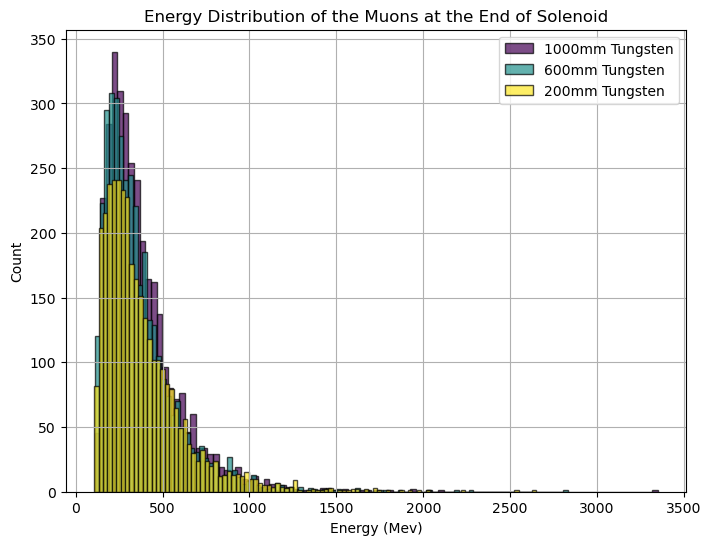

Plot saved to Compare_EProtons_TungstenSize.png


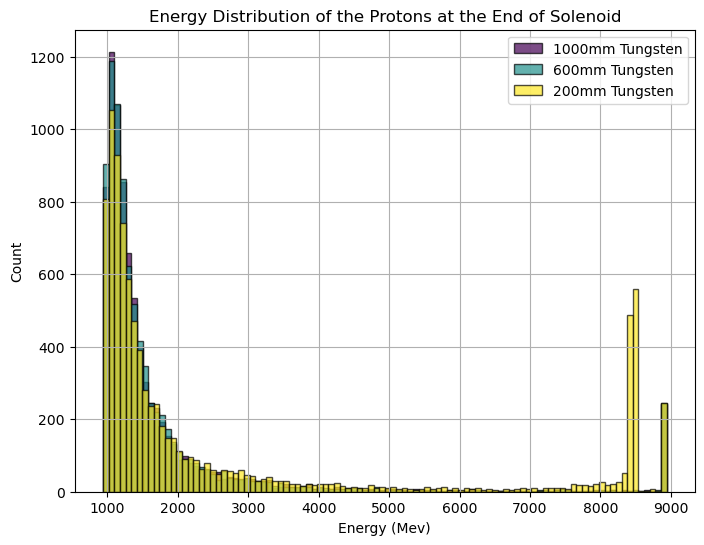

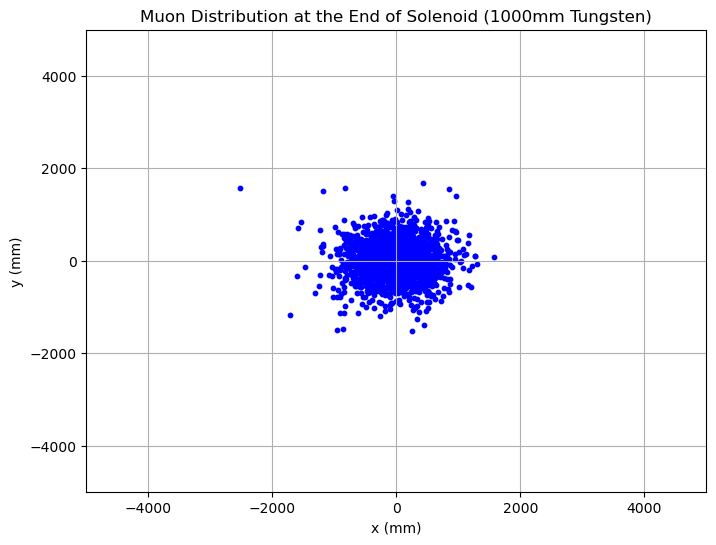

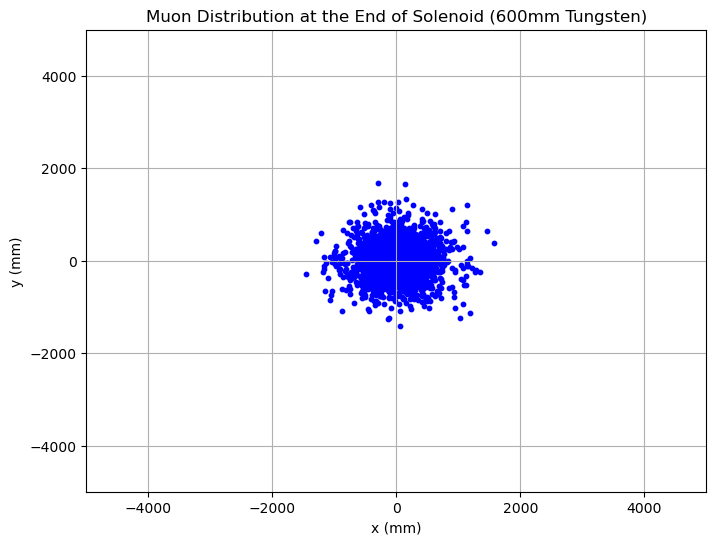

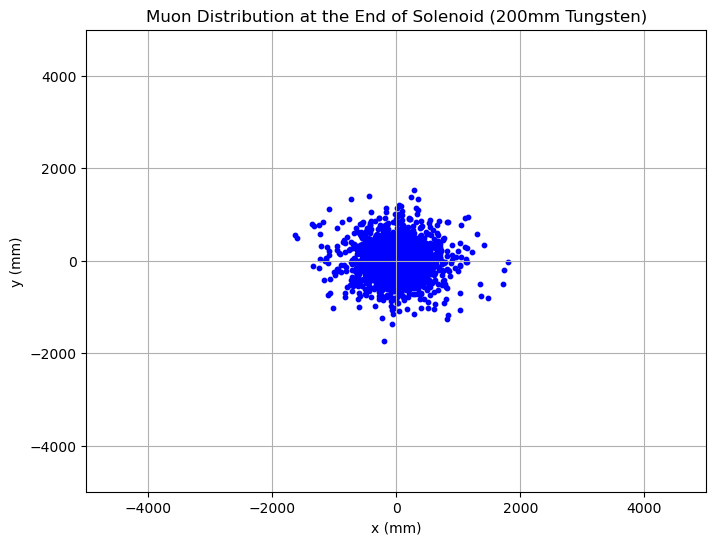

In [4]:
# Check if PDG ID data was successfully extracted
if pdg_ids_1000 is not None and pdg_ids_600 is not None and pdg_ids_200 is not None:
    # Convert to numpy array (for compatibility)
    pdg_ids_1000 = ak.to_numpy(pdg_ids_1000).astype(int)
    pdg_ids_600 = ak.to_numpy(pdg_ids_600).astype(int)
    pdg_ids_200 = ak.to_numpy(pdg_ids_200).astype(int)

    # PDG ID for muons, pions, and kaons 
    PDGID_muons = [-13, 13]
    PDGID_muons_pions_kaons = [13, -13, 211, -211, 321, -321]
    
    # Apply PDG ID filtering 
    select_muons_1000 = filter_by_pdgid(pdg_ids_1000, PDGID_muons)
    select_muons_600 = filter_by_pdgid(pdg_ids_600, PDGID_muons)
    select_muons_200 = filter_by_pdgid(pdg_ids_200, PDGID_muons)
    
    select_muons_pions_kaons_1000 = filter_by_pdgid(pdg_ids_1000, PDGID_muons_pions_kaons)
    select_muons_pions_kaons_600 = filter_by_pdgid(pdg_ids_600, PDGID_muons_pions_kaons)
    select_muons_pions_kaons_200 = filter_by_pdgid(pdg_ids_200, PDGID_muons_pions_kaons)

    select_protons_1000 = filter_by_pdgid(pdg_ids_1000, 2212)
    select_protons_600 = filter_by_pdgid(pdg_ids_600, 2212)
    select_protons_200 = filter_by_pdgid(pdg_ids_200, 2212)
    

    # Extract positions x, y for muons
    x_Muons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "x")[select_muons_1000]
    y_Muons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "y")[select_muons_1000]

    x_Muons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "x")[select_muons_600]
    y_Muons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "y")[select_muons_600]

    x_Muons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "x")[select_muons_200]
    y_Muons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "y")[select_muons_200]

    # Calculate Muons Energies
    Px_Muons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "Px")[select_muons_1000]
    Py_Muons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "Py")[select_muons_1000]
    Pz_Muons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "Pz")[select_muons_1000]

    Px_Muons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "Px")[select_muons_600]
    Py_Muons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "Py")[select_muons_600]
    Pz_Muons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "Pz")[select_muons_600]
    
    Px_Muons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "Px")[select_muons_200]
    Py_Muons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "Py")[select_muons_200]
    Pz_Muons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "Pz")[select_muons_200]

    Muon_Mass = 105.67 # MeV

    E_Muons_1000 = np.sqrt(Muon_Mass**2 + Px_Muons_1000**2 + Py_Muons_1000**2 + Pz_Muons_1000**2)
    E_Muons_600 = np.sqrt(Muon_Mass**2 + Px_Muons_600**2 + Py_Muons_600**2 + Pz_Muons_600**2)
    E_Muons_200 = np.sqrt(Muon_Mass**2 + Px_Muons_200**2 + Py_Muons_200**2 + Pz_Muons_200**2)
    
    # Calculate Protons Energies
    Px_Protons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "Px")[select_protons_1000]
    Py_Protons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "Py")[select_protons_1000]
    Pz_Protons_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "Pz")[select_protons_1000]

    Px_Protons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "Px")[select_protons_600]
    Py_Protons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "Py")[select_protons_600]
    Pz_Protons_600 = get_virtual_detector_data(dataset_600, detector_key_600, "Pz")[select_protons_600]
    
    Px_Protons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "Px")[select_protons_200]
    Py_Protons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "Py")[select_protons_200]
    Pz_Protons_200 = get_virtual_detector_data(dataset_200, detector_key_200, "Pz")[select_protons_200]

    Protons_Mass = 938.27 # MeV

    E_Protons_1000 = np.sqrt(Protons_Mass**2 + Px_Protons_1000**2 + Py_Protons_1000**2 + Pz_Protons_1000**2)
    E_Protons_600 = np.sqrt(Protons_Mass**2 + Px_Protons_600**2 + Py_Protons_600**2 + Pz_Protons_600**2)
    E_Protons_200 = np.sqrt(Protons_Mass**2 + Px_Protons_200**2 + Py_Protons_200**2 + Pz_Protons_200**2)
    
    # Plot 1D histogram of PDG IDs 
    plot_1D_histogram(
    pdg_ids_1000[select_muons_pions_kaons_1000], "PDG ID",
    "PDG ID Distribution at the End of Solenoid (1000mm Tungsten)",
    discrete=True, save_path="PDGID_1000mm_muons_pions_kaons.png"
    )

    plot_1D_histogram(
    pdg_ids_600[select_muons_pions_kaons_600], "PDG ID",
    "PDG ID Distribution at the End of Solenoid (600mm Tungsten)",
    discrete=True, save_path="PDGID_600mm_muons_pions_kaons.png"
    )

    plot_1D_histogram(
    pdg_ids_200[select_muons_pions_kaons_200], "PDG ID",
    "PDG ID Distribution at the End of Solenoid (200mm Tungsten)",
    discrete=True, save_path="PDGID_200mm_muons_pions_kaons.png"
    )

    plot_1D_histogram(
    pdg_ids_1000[select_protons_1000], "PDG ID",
    "PDG ID Distribution at the End of Solenoid (1000mm Tungsten)",
    discrete=True, save_path="PDGID_1000mm_protons.png"
    )

    plot_1D_histogram(
    pdg_ids_600[select_protons_600], "PDG ID",
    "PDG ID Distribution at the End of Solenoid (600mm Tungsten)",
    discrete=True, save_path="PDGID_600mm_protons.png"
    )

    plot_1D_histogram(
    pdg_ids_200[select_protons_200], "PDG ID",
    "PDG ID Distribution at the End of Solenoid (200mm Tungsten)",
    discrete=True, save_path="PDGID_200mm_protons.png"
    )

    # Plot 1D histogram of Energies 
    plot_1D_histogram(
    E_Protons_1000, "Energy (MeV)",
    "Energy Distribution of the Protons at the End of Solenoid (1000mm Tungsten)",
    save_path="E_Protons_1000mm.png", bins=100
    )
    
    plot_1D_histogram(
    E_Protons_600, "Energy (MeV)",
    "Energy Distribution of the Protons at the End of Solenoid (600mm Tungsten)",
    save_path="E_Protons_600mm.png", bins=100
    )
    
    plot_1D_histogram(
    E_Protons_200, "Energy (MeV)",
    "Energy Distribution of the Protons at the End of Solenoid (200mm Tungsten)",
    save_path="E_Protons_200mm.png", bins=100
    )
    
    plot_1D_histogram(
    E_Muons_1000, "Energy (MeV)",
    "Energy Distribution of the Muons at the End of Solenoid (1000mm Tungsten)",
    save_path="E_Muons_1000mm.png", bins=100
    )
    
    plot_1D_histogram(
    E_Muons_600, "Energy (MeV)",
    "Energy Distribution of the Muons at the End of Solenoid (600mm Tungsten)",
    save_path="E_Muons_600mm.png", bins=100
    )
    
    plot_1D_histogram(
    E_Muons_200, "Energy (MeV)",
    "Energy Distribution of the Muons at the End of Solenoid (200mm Tungsten)",
    save_path="E_Muons_200mm.png", bins=100
    )

    # Plot stacked 1D histogram of PDG IDs with custom x-axis limits
    plot_1D_histogram_overlay(
    datasets=[pdg_ids_1000[select_muons_pions_kaons_1000], pdg_ids_600[select_muons_pions_kaons_600], pdg_ids_200[select_muons_pions_kaons_200]], 
    labels=["1000mm Tungsten", "600mm Tungsten", "200mm Tungsten"], 
    xlabel="PDG ID", 
    title="PDG ID Distribution at the End of Solenoid",
    discrete=True,
    save_path="Compare_PDGID_TungstenSize.png",
    colors=["b", "g", "r"]
    )

    plot_1D_histogram_overlay(
    datasets=[E_Muons_1000, E_Muons_600, E_Muons_200], 
    labels=["1000mm Tungsten", "600mm Tungsten", "200mm Tungsten"], 
    xlabel="Energy (Mev)", 
    title="Energy Distribution of the Muons at the End of Solenoid",
    bins=100,
    save_path="Compare_EMuons_TungstenSize.png"
    )

    plot_1D_histogram_overlay(
    datasets=[E_Protons_1000, E_Protons_600, E_Protons_200], 
    labels=["1000mm Tungsten", "600mm Tungsten", "200mm Tungsten"], 
    xlabel="Energy (Mev)", 
    title="Energy Distribution of the Protons at the End of Solenoid",
    bins=100,
    save_path="Compare_EProtons_TungstenSize.png"
    )

    # Plot 2D scatter (x vs y) for filtered muons
    plot_scatter(x_Muons_1000, y_Muons_1000, "x (mm)", "y (mm)", "Muon Distribution at the End of Solenoid (1000mm Tungsten)",(-5000, 5000), (-5000, 5000))
    plot_scatter(x_Muons_600, y_Muons_600, "x (mm)", "y (mm)", "Muon Distribution at the End of Solenoid (600mm Tungsten)",(-5000, 5000), (-5000, 5000))
    plot_scatter(x_Muons_200, y_Muons_200, "x (mm)", "y (mm)", "Muon Distribution at the End of Solenoid (200mm Tungsten)",(-5000, 5000), (-5000, 5000))
else:
    print("Failed to retrieve PDG ID data.")

Saved plot to Compare_Magneticfield_4T_6T_8T.png


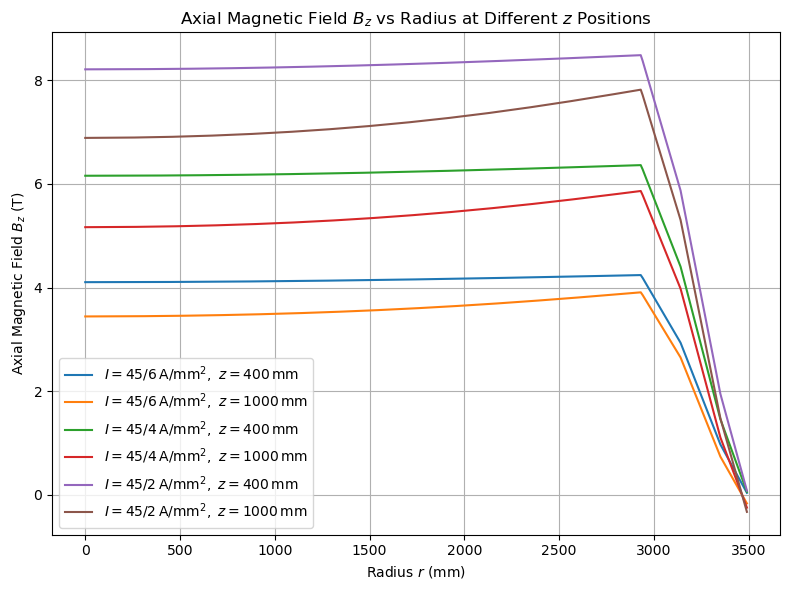

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def load_solenoid_field(filepath):
    """
    Load solenoid field data from a G4beamline-style printfield file.
    Returns a NumPy array with columns: r, z, Br, Bz
    """
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip().startswith("data"):
                break  # Found start of data section
        for line in f:
            if line.strip():
                tokens = line.strip().split()
                if len(tokens) == 4:
                    r, z, Br, Bz = map(float, tokens)
                    data.append((r, z, Br, Bz))
    return np.array(data)

def plot_Bz_vs_r(files, labels, title="Axial Magnetic Field $B_z$ vs Radius", save_path=None):
    """
    Plot Bz vs r from one or more files.

    Args:
        files (list of str): List of file paths.
        labels (list of str): Labels for each dataset.
        title (str): Plot title.
        save_path (str or None): Path to save figure, if desired.
    """
    plt.figure(figsize=(8, 6))

    for filepath, label in zip(files, labels):
        data = load_solenoid_field(filepath)
        r, Bz = data[:, 0], data[:, 3]
        plt.plot(r, Bz, label=label)

    plt.xlabel("Radius $r$ (mm)")
    plt.ylabel("Axial Magnetic Field $B_z$ (T)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to {save_path}")

    plt.show()

file1 = "./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/solenoid_field_cylinder_Z0_400.txt"
file2 = "./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/solenoid_field_cylinder_Z0_1000.txt"
file3 = "./TungstenTarget-50x50x600_Solenoid-6T-3000x12500/solenoid_field_cylinder_Z0_400.txt"
file4 = "./TungstenTarget-50x50x600_Solenoid-6T-3000x12500/solenoid_field_cylinder_Z0_1000.txt"
file5 = "./TungstenTarget-50x50x600_Solenoid-8T-3000x12500/solenoid_field_cylinder_Z0_400.txt"
file6 = "./TungstenTarget-50x50x600_Solenoid-8T-3000x12500/solenoid_field_cylinder_Z0_1000.txt"

plot_Bz_vs_r(
    files=[file1, file2, file3, file4, file5, file6],
    labels=[
        r"$I = 45/6\,\mathrm{A/mm^2},\ z = 400\,\mathrm{mm}$",
        r"$I = 45/6\,\mathrm{A/mm^2},\ z = 1000\,\mathrm{mm}$",
        r"$I = 45/4\,\mathrm{A/mm^2},\ z = 400\,\mathrm{mm}$",
        r"$I = 45/4\,\mathrm{A/mm^2},\ z = 1000\,\mathrm{mm}$",
        r"$I = 45/2\,\mathrm{A/mm^2},\ z = 400\,\mathrm{mm}$",
        r"$I = 45/2\,\mathrm{A/mm^2},\ z = 1000\,\mathrm{mm}$",
    ],
    title=r"Axial Magnetic Field $B_z$ vs Radius at Different $z$ Positions",
    save_path="Compare_Magneticfield_4T_6T_8T.png"
)



In [5]:
# Load datasets
dataset_1000 = load_dataset('./TungstenTarget-50x50x1000_Solenoid-4T-3000x12500/TungstenTarget-50x50x1000_Solenoid-4T-3000x12500.root')
dataset_600 = load_dataset('./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/TungstenTarget-50x50x600_Solenoid-4T-3000x12500.root')
dataset_200 = load_dataset('./TungstenTarget-50x50x200_Solenoid-4T-3000x12500/TungstenTarget-50x50x200_Solenoid-4T-3000x12500.root')

# List available detectors
detectors_1000 = list_detector_keys(dataset_1000)
detectors_600 = list_detector_keys(dataset_600)
detectors_200 = list_detector_keys(dataset_200)
print("Available Detectors in Dataset 1000:", detectors_1000)
print("Available Detectors in Dataset 600:", detectors_600)
print("Available Detectors in Dataset 200:", detectors_200)

# Choose a virtual detector position
detector_key_1000 = "Det_1150cm_Solenoid"
detector_key_600 = "Det_1190cm_Solenoid"
detector_key_200 = "Det_1230cm_Solenoid"

# Extract PDG ID data from the chosen detector
pdg_ids_1000 = get_virtual_detector_data(dataset_1000, detector_key_1000, "PDGid")
pdg_ids_600 = get_virtual_detector_data(dataset_600, detector_key_600, "PDGid")
pdg_ids_200 = get_virtual_detector_data(dataset_200, detector_key_200, "PDGid")

Loaded dataset: ./TungstenTarget-50x50x1000_Solenoid-4T-3000x12500/TungstenTarget-50x50x1000_Solenoid-4T-3000x12500.root
Loaded dataset: ./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/TungstenTarget-50x50x600_Solenoid-4T-3000x12500.root
Loaded dataset: ./TungstenTarget-50x50x200_Solenoid-4T-3000x12500/TungstenTarget-50x50x200_Solenoid-4T-3000x12500.root
Available Detectors in Dataset 1000: ['Det_-50cm_Solenoid;1', 'Det_400cm_Solenoid;1', 'Det_600cm_Solenoid;1', 'Det_800cm_Solenoid;1', 'Det_1000cm_Solenoid;1', 'Det_1150cm_Solenoid;1', 'Det_2000cm_Solenoid;1', 'Det_3000cm_Solenoid;1', 'Det_4000cm_Solenoid;1', 'DetBackward_Solenoid;1', 'DetSideways_Solenoid;1', 'DetForward_Solenoid;1']
Available Detectors in Dataset 600: ['Det_-30cm_Solenoid;1', 'Det_400cm_Solenoid;1', 'Det_600cm_Solenoid;1', 'Det_800cm_Solenoid;1', 'Det_1000cm_Solenoid;1', 'Det_1190cm_Solenoid;1', 'Det_2000cm_Solenoid;1', 'Det_3000cm_Solenoid;1', 'Det_4000cm_Solenoid;1', 'DetBackward_Solenoid;1', 'DetSideways_Solenoid

Loaded dataset: ./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/TungstenTarget-50x50x600_Solenoid-4T-3000x12500.root
Loaded dataset: ./TungstenTarget-50x50x600_Solenoid-6T-3000x12500/TungstenTarget-50x50x600_Solenoid-6T-3000x12500.root
Loaded dataset: ./TungstenTarget-50x50x600_Solenoid-8T-3000x12500/TungstenTarget-50x50x600_Solenoid-8T-3000x12500.root
Plot saved to Compare_PDGID_Overlay_Solenoid600mm_Magneticfield.png


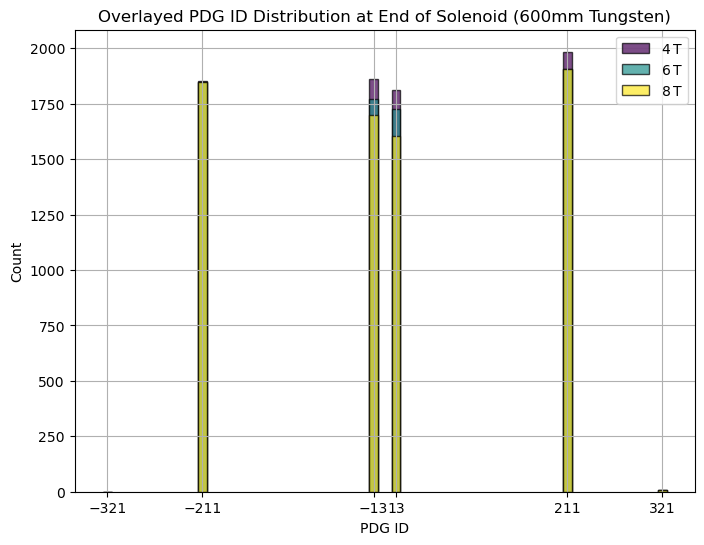

Plot saved to Muon_Energy_Solenoid600mm_Magneticfield.png


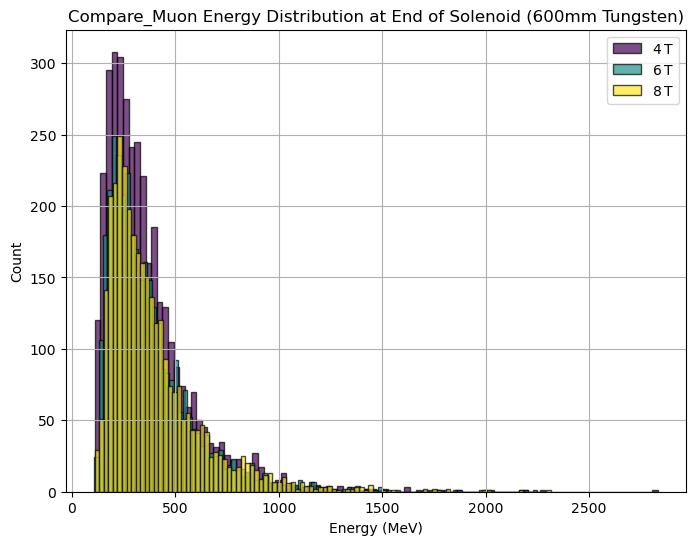

Plot saved to Compare_Proton_Energy_Solenoid600mm_Magneticfield.png


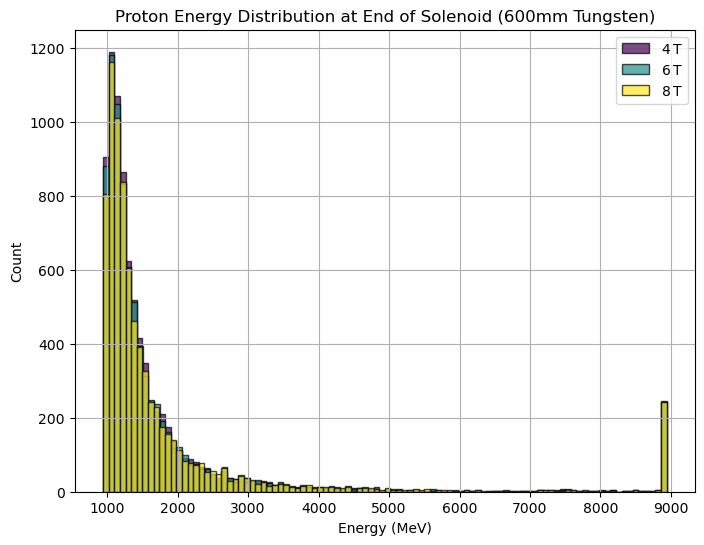

Plot saved to Muon_Distribution_600mm_4T.png


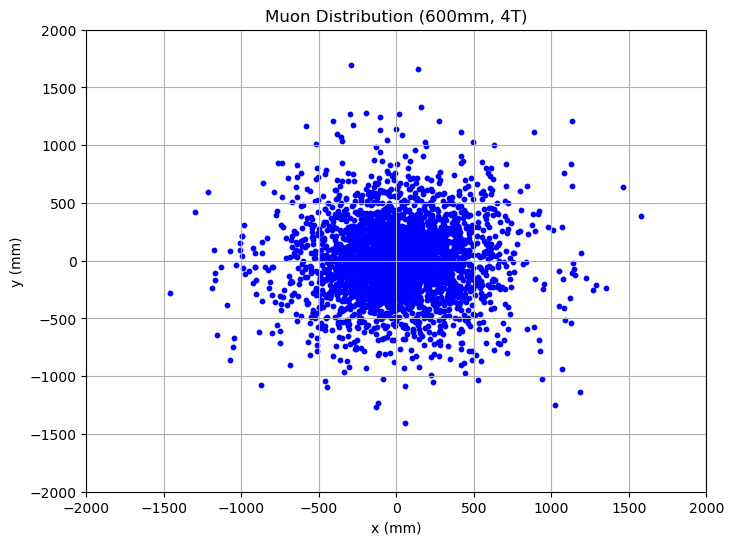

Plot saved to Muon_Distribution_600mm_6T.png


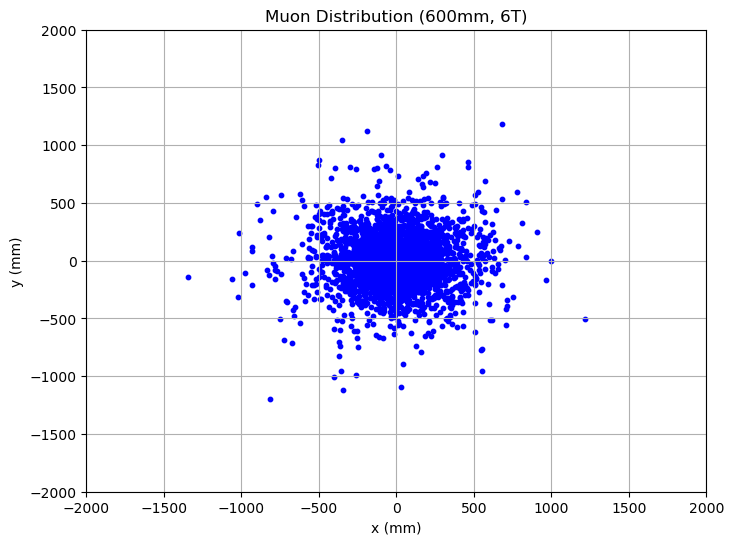

Plot saved to Muon_Distribution_600mm_8T.png


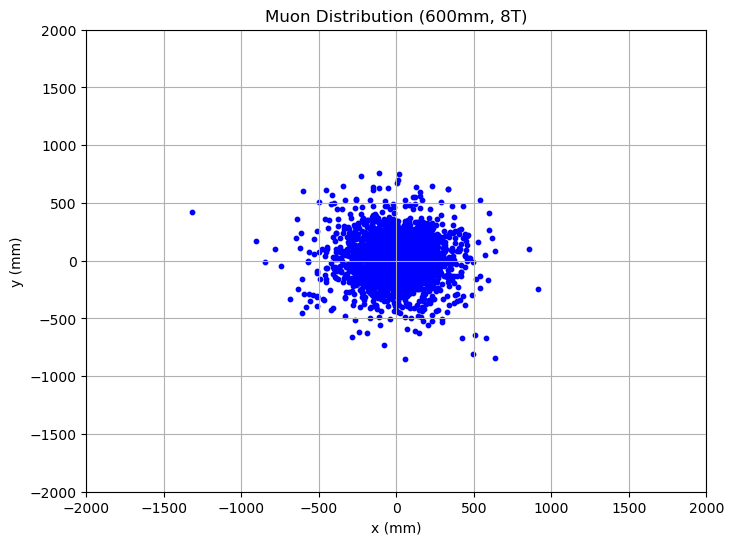

In [6]:
# Load Datasets
dataset_4T = load_dataset('./TungstenTarget-50x50x600_Solenoid-4T-3000x12500/TungstenTarget-50x50x600_Solenoid-4T-3000x12500.root')
dataset_6T = load_dataset('./TungstenTarget-50x50x600_Solenoid-6T-3000x12500/TungstenTarget-50x50x600_Solenoid-6T-3000x12500.root')
dataset_8T = load_dataset('./TungstenTarget-50x50x600_Solenoid-8T-3000x12500/TungstenTarget-50x50x600_Solenoid-8T-3000x12500.root')

# Detector key
detector_key = "Det_1190cm_Solenoid"

# Extract PDG ID data
pdg_ids_4T = get_virtual_detector_data(dataset_4T, detector_key, "PDGid")
pdg_ids_6T = get_virtual_detector_data(dataset_6T, detector_key, "PDGid")
pdg_ids_8T = get_virtual_detector_data(dataset_8T, detector_key, "PDGid")

if pdg_ids_4T is not None and pdg_ids_6T is not None and pdg_ids_8T is not None:
    # Convert to NumPy
    pdg_ids_4T = ak.to_numpy(pdg_ids_4T).astype(int)
    pdg_ids_6T = ak.to_numpy(pdg_ids_6T).astype(int)
    pdg_ids_8T = ak.to_numpy(pdg_ids_8T).astype(int)

    # PDG ID filters
    PDGID_muons = [-13, 13]
    PDGID_muons_pions_kaons = [13, -13, 211, -211, 321, -321]

    # Apply PDG ID filtering
    mask_mu_4T = filter_by_pdgid(pdg_ids_4T, PDGID_muons)
    mask_mu_6T = filter_by_pdgid(pdg_ids_6T, PDGID_muons)
    mask_mu_8T = filter_by_pdgid(pdg_ids_8T, PDGID_muons)

    mask_mpk_4T = filter_by_pdgid(pdg_ids_4T, PDGID_muons_pions_kaons)
    mask_mpk_6T = filter_by_pdgid(pdg_ids_6T, PDGID_muons_pions_kaons)
    mask_mpk_8T = filter_by_pdgid(pdg_ids_8T, PDGID_muons_pions_kaons)

    mask_pr_4T = filter_by_pdgid(pdg_ids_4T, 2212)
    mask_pr_6T = filter_by_pdgid(pdg_ids_6T, 2212)
    mask_pr_8T = filter_by_pdgid(pdg_ids_8T, 2212)

    # Get positions
    def get_xy(dataset, mask):
        x = get_virtual_detector_data(dataset, detector_key, "x")[mask]
        y = get_virtual_detector_data(dataset, detector_key, "y")[mask]
        return x, y

    x_mu_4T, y_mu_4T = get_xy(dataset_4T, mask_mu_4T)
    x_mu_6T, y_mu_6T = get_xy(dataset_6T, mask_mu_6T)
    x_mu_8T, y_mu_8T = get_xy(dataset_8T, mask_mu_8T)

    # Get momenta
    def get_momenta(dataset, mask):
        px = get_virtual_detector_data(dataset, detector_key, "Px")[mask]
        py = get_virtual_detector_data(dataset, detector_key, "Py")[mask]
        pz = get_virtual_detector_data(dataset, detector_key, "Pz")[mask]
        return px, py, pz

    Px_mu_4T, Py_mu_4T, Pz_mu_4T = get_momenta(dataset_4T, mask_mu_4T)
    Px_mu_6T, Py_mu_6T, Pz_mu_6T = get_momenta(dataset_6T, mask_mu_6T)
    Px_mu_8T, Py_mu_8T, Pz_mu_8T = get_momenta(dataset_8T, mask_mu_8T)

    Px_pr_4T, Py_pr_4T, Pz_pr_4T = get_momenta(dataset_4T, mask_pr_4T)
    Px_pr_6T, Py_pr_6T, Pz_pr_6T = get_momenta(dataset_6T, mask_pr_6T)
    Px_pr_8T, Py_pr_8T, Pz_pr_8T = get_momenta(dataset_8T, mask_pr_8T)

    # Masses
    mu_mass = 105.67
    pr_mass = 938.27

    # Energies
    E_mu_4T = np.sqrt(mu_mass**2 + Px_mu_4T**2 + Py_mu_4T**2 + Pz_mu_4T**2)
    E_mu_6T = np.sqrt(mu_mass**2 + Px_mu_6T**2 + Py_mu_6T**2 + Pz_mu_6T**2)
    E_mu_8T = np.sqrt(mu_mass**2 + Px_mu_8T**2 + Py_mu_8T**2 + Pz_mu_8T**2)

    E_pr_4T = np.sqrt(pr_mass**2 + Px_pr_4T**2 + Py_pr_4T**2 + Pz_pr_4T**2)
    E_pr_6T = np.sqrt(pr_mass**2 + Px_pr_6T**2 + Py_pr_6T**2 + Pz_pr_6T**2)
    E_pr_8T = np.sqrt(pr_mass**2 + Px_pr_8T**2 + Py_pr_8T**2 + Pz_pr_8T**2)

    # PDG ID Plots
    plot_1D_histogram_overlay(
        datasets=[pdg_ids_4T[mask_mpk_4T], pdg_ids_6T[mask_mpk_6T], pdg_ids_8T[mask_mpk_8T]],
        labels=[r"$4\,\mathrm{T}$", r"$6\,\mathrm{T}$", r"$8\,\mathrm{T}$"],
        xlabel="PDG ID",
        title="Overlayed PDG ID Distribution at End of Solenoid (600mm Tungsten)",
        discrete=True,
        save_path="Compare_PDGID_Overlay_Solenoid600mm_Magneticfield.png"
    )
    
    # Energy plots (muons and protons)
    plot_1D_histogram_overlay(
        datasets=[E_mu_4T, E_mu_6T, E_mu_8T],
        labels=[r"$4\,\mathrm{T}$", r"$6\,\mathrm{T}$", r"$8\,\mathrm{T}$"],
        xlabel="Energy (MeV)",
        title="Compare_Muon Energy Distribution at End of Solenoid (600mm Tungsten)",
        bins=100,
        save_path="Muon_Energy_Solenoid600mm_Magneticfield.png"
    )
    
    plot_1D_histogram_overlay(
        datasets=[E_pr_4T, E_pr_6T, E_pr_8T],
        labels=[r"$4\,\mathrm{T}$", r"$6\,\mathrm{T}$", r"$8\,\mathrm{T}$"],
        xlabel="Energy (MeV)",
        title="Proton Energy Distribution at End of Solenoid (600mm Tungsten)",
        bins=100,
        save_path="Compare_Proton_Energy_Solenoid600mm_Magneticfield.png"
    )
    
    # 2D scatter plots for muons
    plot_scatter(
        x_mu_4T, y_mu_4T, "x (mm)", "y (mm)", "Muon Distribution (600mm, 4T)", 
        (-2000, 2000), (-2000, 2000), save_path="Muon_Distribution_600mm_4T.png"
    )
    
    plot_scatter(
        x_mu_6T, y_mu_6T, "x (mm)", "y (mm)", "Muon Distribution (600mm, 6T)", 
        (-2000, 2000), (-2000, 2000), save_path="Muon_Distribution_600mm_6T.png"
    )
    
    plot_scatter(
        x_mu_8T, y_mu_8T, "x (mm)", "y (mm)", "Muon Distribution (600mm, 8T)", 
        (-2000, 2000), (-2000, 2000), save_path="Muon_Distribution_600mm_8T.png"
    )

else:
    print("Failed to retrieve PDG ID data.")


In [7]:
# # --------------------------------------------
# # Example Usage: Loading and Plotting Data
# # --------------------------------------------

# # Load datasets
# dataset_1000 = load_dataset('./TungstenTarget-50x50x1000_Solenoid-4T-3000x12500/TungstenTarget-50x50x1000_Solenoid-4T-3000x12500.root')
# dataset_200 = load_dataset('TungstenTarget-50x50x200_Solenoid-4T-3000x12500/TungstenTarget-50x50x200_Solenoid-4T-3000x12500.root')

# # List available detectors
# detectors_1000 = list_detector_keys(dataset_1000)
# detectors_200 = list_detector_keys(dataset_200)
# print("Available Detectors in Dataset 1000:", detectors_1000)
# print("Available Detectors in Dataset 200:", detectors_200)

# # Choose a virtual detector position (example: 'Det_400cm_Solenoid')
# detector_key = "Det_400cm_Solenoid"

# # Extract PDG ID data from the chosen detector
# pdg_ids_1000 = get_virtual_detector_data(dataset_1000, detector_key, "PDGid")
# pdg_ids_200 = get_virtual_detector_data(dataset_200, detector_key, "PDGid")

# # Check if PDG ID data was successfully extracted
# if pdg_ids_1000 is not None and pdg_ids_200 is not None:
#     # Convert to numpy array (for compatibility)
#     pdg_ids_1000 = ak.to_numpy(pdg_ids_1000).astype(int)
#     pdg_ids_200 = ak.to_numpy(pdg_ids_200).astype(int)

#     # Apply PDG ID filtering (e.g., only select muons PDG ID = ±13)
#     mask_muons_1000 = filter_by_pdgid(pdg_ids_1000, 13, -13)
#     mask_muons_200 = filter_by_pdgid(pdg_ids_200, 13, -13)

#     mask_protons_neutrons_1000 = filter_by_pdgid(pdg_ids_1000, 2212, 2112)
#     mask_protons_neutrons_200 = filter_by_pdgid(pdg_ids_200, 2212, 2112)
    

#     # Extract positions x, y for muons
#     x_1000 = get_virtual_detector_data(dataset_1000, detector_key, "x")[mask_muons_1000]
#     y_1000 = get_virtual_detector_data(dataset_1000, detector_key, "y")[mask_muons_1000]

#     x_200 = get_virtual_detector_data(dataset_200, detector_key, "x")[mask_muons_200]
#     y_200 = get_virtual_detector_data(dataset_200, detector_key, "y")[mask_muons_200]

#     # Plot 1D histogram of PDG IDs (Full dataset)
#     plot_1D_histogram(pdg_ids_1000, "PDG ID", "PDG ID Distribution", xlim=(0, 100))
#     plot_1D_histogram(pdg_ids_1000, "PDG ID", "PDG ID Distribution at 400cm (1000mm Tungsten)")
#     plot_1D_histogram(pdg_ids_200, "PDG ID", "PDG ID Distribution at 400cm (200mm Tungsten)")
#     plot_1D_histogram(pdg_ids_1000[mask_protons_neutrons_1000], "PDG ID", "PDG ID Distribution at 400cm (1000mm Tungsten)", bins=np.unique(pdg_ids_1000[mask_protons_neutrons_1000]))
#     plot_1D_histogram(pdg_ids_200[mask_protons_neutrons_200], "PDG ID", "PDG ID Distribution at 400cm (200mm Tungsten)", bins=np.unique(pdg_ids_200[mask_protons_neutrons_200]))

#     # Plot stacked 1D histogram of PDG IDs with custom x-axis limits
#     plot_1D_histogram_stacked(
#     datasets=[pdg_ids_1000[mask_muons_1000], pdg_ids_200[mask_muons_200]], 
#     labels=["1000mm Tungsten", "200mm Tungsten"], 
#     xlabel="PDG ID", 
#     title="Stacked PDG ID Distribution at 400cm",
#     discrete=True
#     )


#     # # Plot 2D histogram (x vs y) for filtered muons
#     # plot_2D_histogram(x_1000, y_1000, "x (mm)", "y (mm)", "Muon Distribution at 400cm (1000mm Tungsten)", (-3000, 3000), (-3000, 3000),-1, 100, bins=500)

#     # plot_2D_histogram(x_200, y_200, "x (mm)", "y (mm)", "Muon Distribution at 400cm (200mm Tungsten)")

#     # Plot 2D scatter (x vs y) for filtered muons
#     plot_scatter(x_1000, y_1000, "x (mm)", "y (mm)", "Muon Distribution at 400cm (1000mm Tungsten)",(-5000, 5000), (-5000, 5000))
#     plot_scatter(x_200, y_200, "x (mm)", "y (mm)", "Muon Distribution at 400cm (200mm Tungsten)")
# else:
#     print("Failed to retrieve PDG ID data.")


In [8]:
# def plot_1D_histogram_discrete(data, xlabel, title):
#     """
#     Plot a 1D histogram where x-axis has discrete unique values.

#     Args:
#         data (array-like): The data to plot.
#         xlabel (str): Label for the x-axis.
#         title (str): Title of the histogram.
#     """
#     unique_values, counts = np.unique(data, return_counts=True)

#     plt.figure(figsize=(8, 6))
#     plt.bar(unique_values, counts, width=1.0, edgecolor='black', alpha=0.7)

#     plt.xlabel(xlabel)
#     plt.ylabel("Count")
#     plt.title(title)
#     plt.xticks(unique_values)  # Ensure only discrete values are labeled
#     plt.grid(True, axis='y')
#     plt.show()

# # Apply boolean masks to filter PDG ID values
# filtered_pdg_ids_1000 = pdg_ids_1000[mask_protons_neutrons_1000]
# filtered_pdg_ids_200 = pdg_ids_200[mask_protons_neutrons_200]
# # Now call the function
# plot_1D_histogram_discrete(filtered_pdg_ids_1000, "PDG ID", "PDG ID Distribution at 400cm (1000mm Tungsten)")
# plot_1D_histogram_discrete(filtered_pdg_ids_200, "PDG ID", "PDG ID Distribution at 400cm (200mm Tungsten)")


In [9]:
# def plot_1D_histogram(
#     data,
#     xlabel,
#     title,
#     bins=50,
#     start=None,
#     stop=None,
#     axis_name="variable",
#     category_name=None,
#     category_label=None,
#     category_value=None,
#     is_integer=False
# ):
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(8, 6))  # <-- add this

#     if is_integer:
#         unique_vals = np.unique(data)
#         main_axis = hist.axis.IntCategory(
#             unique_vals,
#             name=axis_name,
#             label=xlabel
#         )
#     else:
#         if start is None:
#             start = float(np.min(data))
#         if stop is None:
#             stop = float(np.max(data))
#         main_axis = hist.axis.Regular(
#             bins,
#             start,
#             stop,
#             name=axis_name,
#             label=xlabel
#         )

#     if category_name and category_label and category_value:
#         cat_axis = hist.axis.StrCategory(
#             categories=[category_value],
#             name=category_name,
#             label=category_label
#         )
#         h = Hist(main_axis, cat_axis)
#         h.fill(**{axis_name: data, category_name: category_value})
#     else:
#         h = Hist(main_axis)
#         h.fill(**{axis_name: data})

#     h.plot()
#     if category_name:
#         plt.legend()
#     plt.title(title)  # <- optional, improves context
#     plt.show()


In [10]:
# def plot_2D_histogram(
#     data_x,
#     data_y,
#     xlabel,
#     ylabel,
#     title,
#     bins=50,
#     x_start=None,
#     x_stop=None,
#     y_start=None,
#     y_stop=None,
#     x_name="x",
#     y_name="y"
# ):
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(8, 6))  # <-- add this

#     if x_start is None:
#         x_start = float(np.min(data_x))
#     if x_stop is None:
#         x_stop = float(np.max(data_x))
#     if y_start is None:
#         y_start = float(np.min(data_y))
#     if y_stop is None:
#         y_stop = float(np.max(data_y))

#     x_axis = hist.axis.Regular(bins, x_start, x_stop, name=x_name, label=xlabel)
#     y_axis = hist.axis.Regular(bins, y_start, y_stop, name=y_name, label=ylabel)

#     h2d = Hist(x_axis, y_axis)
#     h2d.fill(**{x_name: data_x, y_name: data_y})

#     h2d.plot2d()
#     plt.title(title)
#     plt.show()


In [11]:
# # Check if PDG ID data was successfully extracted
# if pdg_ids_1000 is not None and pdg_ids_200 is not None:
#     # Convert to numpy array (for compatibility)
#     pdg_ids_1000 = ak.to_numpy(pdg_ids_1000).astype(int)
#     pdg_ids_200 = ak.to_numpy(pdg_ids_200).astype(int)

#     # Apply PDG ID filtering (e.g., only select muons PDG ID = ±13)
#     mask_muons_1000 = filter_by_pdgid(pdg_ids_1000, 13, -13)
#     mask_muons_200 = filter_by_pdgid(pdg_ids_200, 13, -13)

#     # Extract positions x, y for muons
#     x_1000 = ak.to_numpy(get_virtual_detector_data(dataset_1000, detector_key, "x")[mask_muons_1000])
#     y_1000 = ak.to_numpy(get_virtual_detector_data(dataset_1000, detector_key, "y")[mask_muons_1000])

#     x_200 = ak.to_numpy(get_virtual_detector_data(dataset_200, detector_key, "x")[mask_muons_200])
#     y_200 = ak.to_numpy(get_virtual_detector_data(dataset_200, detector_key, "y")[mask_muons_200])

#     # Plot 1D histogram of PDG IDs (Full dataset) with integer category axis and legend
#     plot_1D_histogram(
#         data=pdg_ids_1000,
#         xlabel="PDG ID",
#         title="PDG ID Distribution at 400 cm (1000mm Tungsten)",
#         axis_name="pdg_id",
#         is_integer=True,
#         category_name="target",
#         category_label="Target",
#         category_value="1000mm"
#     )

#     plot_1D_histogram(
#         data=pdg_ids_200,
#         xlabel="PDG ID",
#         title="PDG ID Distribution at 400 cm (200mm Tungsten)",
#         axis_name="pdg_id",
#         is_integer=True,
#         category_name="target",
#         category_label="Target",
#         category_value="200mm"
#     )

#     # Plot 2D histogram (x vs y) for filtered muons
#     plot_2D_histogram(
#         data_x=x_1000,
#         data_y=y_1000,
#         xlabel="x (mm)",
#         ylabel="y (mm)",
#         title="Muon x-y Distribution at 400 cm (1000mm Tungsten)",
#         x_name="x",
#         y_name="y"
#     )

#     plot_2D_histogram(
#         data_x=x_200,
#         data_y=y_200,
#         xlabel="x (mm)",
#         ylabel="y (mm)",
#         title="Muon x-y Distribution at 400 cm (200mm Tungsten)",
#         x_name="x",
#         y_name="y"
#     )
# else:
#     print("Failed to retrieve PDG ID data.")
